# 한강공원 주차 예측

### 초기 세팅

In [2]:
# pip install requests
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

## 한강공원 API

In [4]:
import requests
import json
import time

# API 데이터 요청 함수
def fetch_data(url):
    # 주어진 URL로 GET 요청을 보내고 응답을 받음
    response = requests.get(url)
    
    # 응답 상태 코드가 200(성공)이면 JSON 데이터를 반환
    if response.status_code == 200:
        return response.json()
    else:
        # 상태 코드가 200이 아니면 오류 메시지 출력
        print(f"Error: {response.status_code}")
        return None

# 실시간 인구 및 혼잡도 정보 추출 함수
def extract_congestion_info(city_data):
    # 'LIVE_PPLTN_STTS' 키로부터 실시간 인구 현황 데이터 추출
    live_ppltn = city_data.get('LIVE_PPLTN_STTS', [])
    # 첫 번째 인구 정보 항목을 가져오거나 없으면 빈 딕셔너리 반환
    congestion_info = live_ppltn[0] if live_ppltn else {}
    
    # 추출한 데이터를 딕셔너리 형태로 반환
    return {
        "장소명": city_data.get("AREA_NM", "정보 없음"),  # 장소명
        "장소 코드": city_data.get("AREA_CD", "정보 없음"),  # 장소 코드
        "장소 혼잡도 지표": congestion_info.get("AREA_CONGEST_LVL", "정보 없음"),  # 혼잡도 지표
        "장소 혼잡도 지표 관련 메세지": congestion_info.get("AREA_CONGEST_MSG", "정보 없음"),  # 혼잡도 메세지
        "실시간 인구 현황": congestion_info.get("AREA_PPLTN_MIN", "정보 없음") + " ~ " + congestion_info.get("AREA_PPLTN_MAX", "정보 없음")  # 실시간 인구 현황
    }

# 주차장 중복 제거 및 최신 정보 선택 함수
def extract_unique_parking_info(city_data):
    # 'PRK_STTS' 키로부터 주차장 상태 정보 추출
    parking_data = city_data.get("PRK_STTS", [])
    unique_parking = {}
    
    # 주차장 데이터에서 중복된 주차장 정보를 제거하고 최신 정보만 유지
    for prk in parking_data:
        key = (prk.get("PRK_NM"), prk.get("PRK_CD"))  # 주차장 이름과 코드로 고유 키 생성
        if key not in unique_parking or prk.get("CUR_PRK_TIME"):  # 최신 정보가 있으면 업데이트
            unique_parking[key] = prk
    
    # 고유한 주차장 정보만 리스트로 반환
    return list(unique_parking.values())

# 날씨 현황 정보 추출 함수
def extract_weather_info(city_data):
    # 'WEATHER_STTS' 키로부터 날씨 상태 데이터 추출 (리스트일 경우 첫 번째 항목 선택)
    weather_data = city_data.get('WEATHER_STTS', [])
    weather_info = weather_data[0] if weather_data else {}  # 첫 번째 항목이 있으면 가져오고, 없으면 빈 딕셔너리
    
    # 추출한 날씨 정보를 딕셔너리 형태로 반환
    return {
        "기온": weather_info.get("TEMP", "정보 없음"),  # 기온
        "체감 온도": weather_info.get("SENSIBLE_TEMP", "정보 없음"),  # 체감 온도
        "습도": weather_info.get("HUMIDITY", "정보 없음"),  # 습도
        "풍향": weather_info.get("WIND_DIRCT", "정보 없음"),  # 바람 방향
        "통합대기환경지수": weather_info.get("AIR_IDX_MVL", "정보 없음"),  # 통합 대기 환경 지수
        "통합대시환경지수메세지": weather_info.get("AIR_MSG", "정보 없음"),  # 통합 대기 환경 지수 메시지
    }

# 전체 데이터 처리 함수
def process_city_data(data):
    # 'CITYDATA' 키로부터 도시 데이터 추출
    city_data = data.get('CITYDATA', {})
    
    # 인구 및 혼잡도 정보 추출
    congestion_info = extract_congestion_info(city_data)
    # 중복된 주차장 정보 처리 후 고유한 주차장 정보 리스트 추출
    unique_parking_list = extract_unique_parking_info(city_data)
    # 날씨 현황 정보 추출
    weather_info = extract_weather_info(city_data)
    
    # 필요한 모든 데이터를 딕셔너리 형태로 반환
    return {
        **congestion_info,  # 인구 및 혼잡도 정보
        "전체도로소통평균속도": city_data.get("ROAD_TRAFFIC_SPD", "정보 없음"),  # 도로 소통 평균 속도
        "도로소통현황 업데이트 시간": city_data.get("ROAD_TRAFFIC_TIME", "정보 없음"),  # 도로 소통 현황 업데이트 시간
        "전체도로소통평균현황 메세지": city_data.get("ROAD_MSG", "정보 없음"),  # 도로 소통 현황 메시지
        "주차장 현황": unique_parking_list,  # 주차장 현황
        **weather_info  # 날씨 현황 정보
    }

# 결과 출력 함수
def print_data(data):
    # 처리된 데이터를 읽기 쉬운 형식으로 출력
    print("\n추출한 데이터 (row 형태):")
    print(json.dumps(data, ensure_ascii=False, indent=4))

# 실행 함수
def main():
    # 시작 시간 기록
    start_time = time.time()

    # API URL 설정 (JSON 형식)
    url = f'http://openapi.seoul.go.kr:8088/434675486868617235394264587a4e/json/citydata/1/1000/{'잠실한강공원'}'

    # 데이터 가져오기
    data = fetch_data(url)
    
    # 데이터가 유효하면 처리 후 출력
    if data:
        processed_data = process_city_data(data)
        print_data(processed_data)

    # 종료 시간 기록 및 실행 시간 출력
    end_time = time.time()
    print(f"\n코드 실행 시간: {end_time - start_time:.4f}초")

# 프로그램 실행
if __name__ == "__main__":
    main()


추출한 데이터 (row 형태):
{
    "장소명": "잠실한강공원",
    "장소 코드": "POI110",
    "장소 혼잡도 지표": "여유",
    "장소 혼잡도 지표 관련 메세지": "사람이 몰려있을 가능성이 낮고 붐빔은 거의 느껴지지 않아요. 도보 이동이 자유로워요.",
    "실시간 인구 현황": "1500 ~ 2000",
    "전체도로소통평균속도": "정보 없음",
    "도로소통현황 업데이트 시간": "정보 없음",
    "전체도로소통평균현황 메세지": "정보 없음",
    "주차장 현황": [
        {
            "PRK_NM": "잠실1, 2, 3, 4주차장",
            "PRK_CD": "1892067",
            "PRK_TYPE": "BP",
            "CPCTY": "471",
            "CUR_PRK_CNT": "471",
            "CUR_PRK_TIME": "2024-11-13 13:59:02",
            "CUR_PRK_YN": "Y",
            "PAY_YN": "Y",
            "RATES": "1000",
            "TIME_RATES": null,
            "ADD_RATES": "200",
            "ADD_TIME_RATES": null,
            "ADDRESS": "송파구 잠실동 1-1 ",
            "ROAD_ADDR": "송파구 한가람로 65",
            "LNG": "127.081214",
            "LAT": "37.517984"
        },
        {
            "PRK_NM": "신천유수지 공영주차장(시)",
            "PRK_CD": "173646",
            "PRK_TYPE": "NW",
            "CPCTY":

---
## 한강 공원 일별 Data 
    Target
- 주차 가능 공간 수
----
    Feature
- 요일
- 시간
- 날씨
- 행사 일정
- 인근 대중교통 이용량
- 주변 인구 밀집도
- 주차 면수
- 이용시간

In [5]:
# 데이터 불러오기
import pandas as pd

# 데이터 일별 주차대수 및 이용시간 현황
df_day = pd.read_csv("../Data/한강공원 주차장 일별 이용 현황.csv", encoding='euc-kr', index_col=False)
# 데이터 월별 공원 
df_month = pd.read_csv("../Data/서울시 한강공원 월별 이용객 현황.csv", encoding='euc-kr', index_col=False)

In [6]:
# 데이터 확인하기
print(f"한강공원 주차장 일별 데이터 :")
print(df_day.info())

한강공원 주차장 일별 데이터 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     45277 non-null  object
 1   주차장명    45277 non-null  object
 2   주차대수    45277 non-null  int64 
 3   이용시간    45277 non-null  int64 
 4   날짜      45277 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB
None


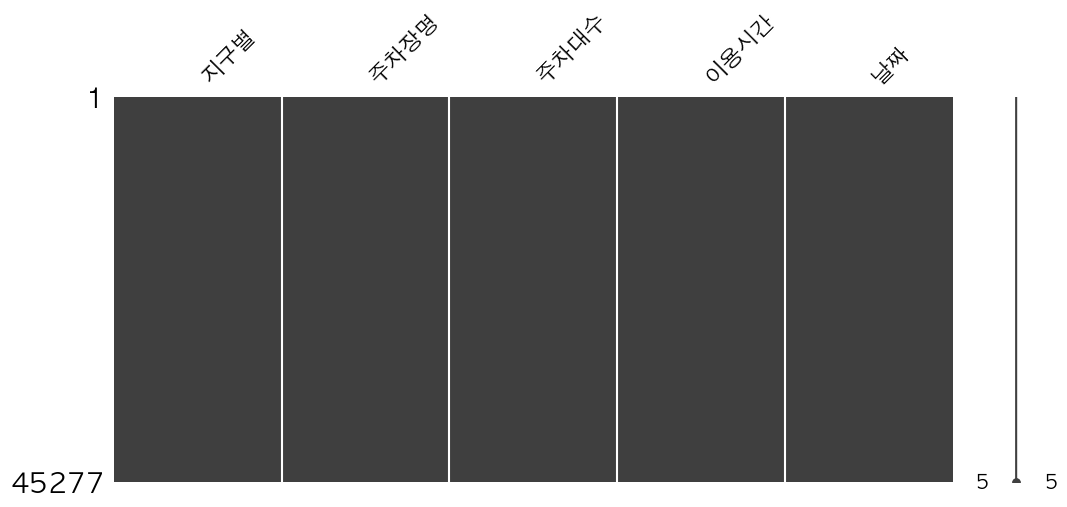

In [7]:
# 결측치 시각화
# train NaN값 시각화
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df_day, figsize=(12, 5))

plt.show()

> 주차장 일별 데이터는 결측치가 없는 것을 확인 할 수 있다.

In [8]:
# 날짜 컬럼을 날짜 형식으로 전환
df_day['날짜'] = pd.to_datetime(df_day['날짜'], format= '%Y/%m/%d')

# 일별 날짜 컬럼을 연,월,일 컬럼으로 분리
df_day['연도'] = df_day['날짜'].dt.year
df_day['월'] = df_day['날짜'].dt.month
df_day['일'] = df_day['날짜'].dt.day

df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10
...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15


In [9]:
# pip install holidays

### 데이터 전처리

### 요일 정보
    0 : 월요일
    1 : 화요일
    2 : 수요일
    3 : 목요일
    4 : 금요일
    5 : 토요일
    6 : 일요일
### 휴일여부 정보
    0 : 평일
    1 : 주말
    2 : 휴일

In [10]:
# 평일 휴일로 분리 및 요일 변환 
import holidays

# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 요일 변환
weekday_map = {0 : 0, 1 : 1, 2 : 2, 3: 3, 4: 4, 5: 5, 6: 6}

# 요일 숫자를 요일 이름으로 변환
df_day['요일'] = df_day['날짜'].dt.weekday.map(weekday_map)

# 날짜가 공휴일인지를 체크하는 함수 추가
df_day['휴일여부'] = df_day['날짜'].apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))

# 데이터 확인
df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1
...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0


> 데이터의 '이용시간' 컬럼이 분 단위이기 때문에 분 단위를 차랑 평균당 시간으로 변환시켜준다.

In [11]:
# 시간 변환
df_day['주차장 이용 시간(H)'] = (df_day['이용시간'] / 60)

In [12]:
# 데이터 확인
df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,주차장 이용 시간(H)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,381.516667
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,1106.016667
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,447.916667
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,375.150000
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,2502.250000
...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,3691.400000
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,5.783333
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,101.216667
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,1.133333


---
## 날씨
- 한강공원에 날씨 기온에 따라 사람들의 인구수 차이가 있는 것을 확인
- 데이터 전처리 및 병합

> 날씨 컬럼 추가하기

In [13]:
# 날씨 CSV FILE 불러오기
weather_seoul = pd.read_csv("../Data/서울날씨20-24.csv", encoding='euc-kr')

# Data 확인하기
weather_seoul.sort_values(by='일시', axis=0,ascending=False, inplace=True)
weather_seoul

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),일강수량(mm),평균 이슬점온도(°C),평균 상대습도(%)
1762,108,서울,2024-11-10,14.4,10.3,536.0,21.0,1520,NaN,NaN,7.4,64.0
1761,108,서울,2024-11-09,12.9,6.8,607.0,20.3,1436,NaN,NaN,3.9,55.8
1760,108,서울,2024-11-08,10.2,3.1,629.0,18.1,1501,NaN,NaN,0.1,50.8
1759,108,서울,2024-11-07,7.8,1.6,707.0,15.7,1515,NaN,NaN,-3.0,48.1
1758,108,서울,2024-11-06,7.5,4.1,628.0,12.5,1430,NaN,NaN,-3.6,46.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,108,서울,2020-01-18,0.3,-4.1,802.0,5.9,1503,NaN,NaN,-10.0,48.1
3,108,서울,2020-01-17,-0.6,-4.8,720.0,4.9,1449,NaN,NaN,-11.7,43.9
2,108,서울,2020-01-16,-1.7,-5.5,816.0,3.2,1430,NaN,NaN,-13.0,43.0
1,108,서울,2020-01-15,-2.7,-6.4,722.0,2.2,1510,NaN,NaN,-13.4,44.8


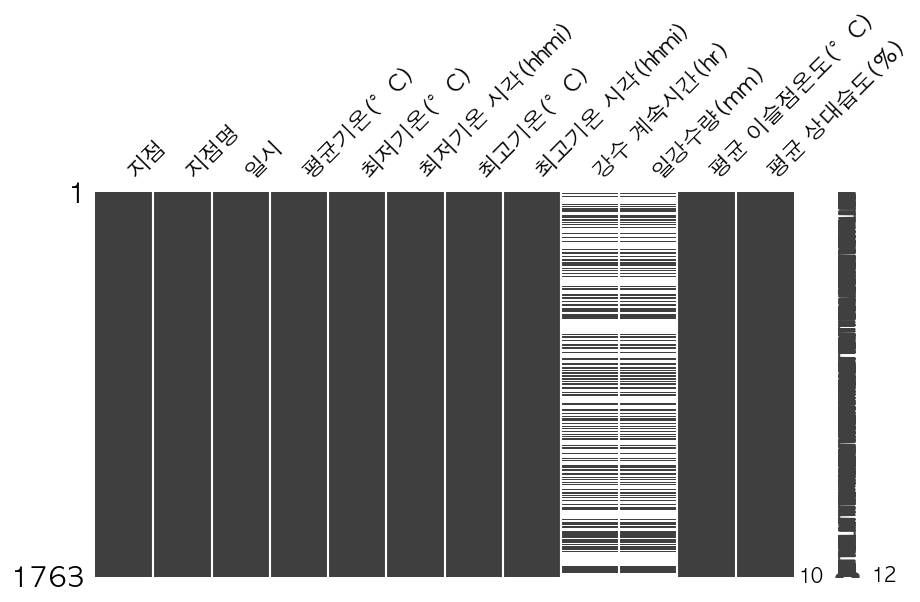

In [14]:
# 결측치 확인하기

msno.matrix(weather_seoul, figsize=(10,5))
plt.show()

> 강수 계속시간과 일 강수량은 결측치가 많은 것으로 확인된다.        
결측치가 많은 이유는 비가 오지 않은 날을 기입을 하지 않은 것으로 보임.

In [15]:
# 일시 컬럼 날짜 컬럼명 KEY 값 연동
weather_seoul['날짜'] = weather_seoul['일시']

In [16]:
# 데이터 변환
weather_seoul['날짜'] = pd.to_datetime(weather_seoul['날짜'], format='%Y-%m-%d')

In [17]:
# 날짜를 기준으로 병합
df_merged = pd.merge(df_day, weather_seoul[['날짜', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 상대습도(%)']],
                     how='left', left_on='날짜', right_on='날짜')

# 병합 결과 확인
df_merged

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,주차장 이용 시간(H),평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도(%)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,381.516667,14.4,10.3,21.0,64.0
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,1106.016667,14.4,10.3,21.0,64.0
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,447.916667,14.4,10.3,21.0,64.0
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,375.150000,14.4,10.3,21.0,64.0
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,2502.250000,14.4,10.3,21.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,3691.400000,-1.7,-5.5,3.2,43.0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,5.783333,-1.7,-5.5,3.2,43.0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,101.216667,-2.7,-6.4,2.2,44.8
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,1.133333,-2.7,-6.4,2.2,44.8


---
## 한강공원 월별 이용객 데이터 불러오기
- 한강공원에 일별 주차 비율(혼잡도)을 예측하기 위해서는 데이터가 부족           
- 월별 데이터를 이용하여 이용자의 '아침', '낮', '저녁'의 비율을 파악        
- 파악한 이유는 비율로 주차장의 데이터를 군집회하기 위함.       

In [18]:
df_month = pd.read_csv("../Data/서울시 한강공원 월별 이용객 현황.csv", encoding='euc-kr')
df_month

,현황 일련번호,공원 코드,공원명,공원 시명,공원 구명,공원 지번 주소,공원 도로명 주소,등록자 일련번호,등록 일시,수정자 일련번호,...,강변물놀이장,강변프롬나드,난지 하늘다리,갈대숲탐장로,꿀벌숲,치유의숲,그라스정원,노들섬,습지생태공원,현황 일시
0,87623,Hzone001,광나루한강공원,서울,강동구,암사동 637-6,선사로 83-106,83,2024-03-08 10:40:48.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
1,87629,Hzone006,이촌한강공원,서울,용산구,이촌동 302-17,이촌로72길 62,83,2024-03-08 14:14:33.0,NaN,...,0,0,0,0,0,0,0,19198,0,2024-02-29 00:00:00.0
2,87626,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,83,2024-03-08 11:29:41.0,83.0,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
3,87625,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,83,2024-03-08 10:44:40.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
4,87631,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,83,2024-03-08 14:40:51.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,86798,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,5,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
811,86802,Hzone007,여의도한강공원,서울,영등포구,여의도동 85-1,여의동로 280,10,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
812,86801,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,11,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
813,86800,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,6,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0


> 월별 데이터를 일별 데이터로 합치기 위해 datetime으로 변환하여 연도,월 컬럼으로 분리작업을 시켜준다.

In [19]:
# 현황 일시가 object type을 datetime으로 변환
df_month['현황 일시'] = pd.to_datetime(df_month['현황 일시'], format='%Y-%m-%d %H:%M:%S.%f')

# 일별 날짜 컬럼을 연도, 월 컬럼으로 분리

df_month['연도'] = df_month['현황 일시'].dt.year
df_month['월'] = df_month['현황 일시'].dt.month

df_month

,현황 일련번호,공원 코드,공원명,공원 시명,공원 구명,공원 지번 주소,공원 도로명 주소,등록자 일련번호,등록 일시,수정자 일련번호,...,난지 하늘다리,갈대숲탐장로,꿀벌숲,치유의숲,그라스정원,노들섬,습지생태공원,현황 일시,연도,월
0,87623,Hzone001,광나루한강공원,서울,강동구,암사동 637-6,선사로 83-106,83,2024-03-08 10:40:48.0,NaN,...,0,0,0,0,0,0,0,2024-02-29,2024,2
1,87629,Hzone006,이촌한강공원,서울,용산구,이촌동 302-17,이촌로72길 62,83,2024-03-08 14:14:33.0,NaN,...,0,0,0,0,0,19198,0,2024-02-29,2024,2
2,87626,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,83,2024-03-08 11:29:41.0,83.0,...,0,0,0,0,0,0,0,2024-02-29,2024,2
3,87625,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,83,2024-03-08 10:44:40.0,NaN,...,0,0,0,0,0,0,0,2024-02-29,2024,2
4,87631,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,83,2024-03-08 14:40:51.0,NaN,...,0,0,0,0,0,0,0,2024-02-29,2024,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,86798,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,5,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,2018-01-31,2018,1
811,86802,Hzone007,여의도한강공원,서울,영등포구,여의도동 85-1,여의동로 280,10,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,2018-01-31,2018,1
812,86801,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,11,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,2018-01-31,2018,1
813,86800,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,6,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,2018-01-31,2018,1


In [20]:
# 데이터 info확인
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 64 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   현황 일련번호      815 non-null    int64         
 1   공원 코드        815 non-null    object        
 2   공원명          815 non-null    object        
 3   공원 시명        815 non-null    object        
 4   공원 구명        815 non-null    object        
 5   공원 지번 주소     815 non-null    object        
 6   공원 도로명 주소    815 non-null    object        
 7   등록자 일련번호     815 non-null    int64         
 8   등록 일시        815 non-null    object        
 9   수정자 일련번호     62 non-null     float64       
 10  수정 일시        62 non-null     object        
 11  일반이용자(아침)    812 non-null    float64       
 12  일반이용자(낮)     815 non-null    int64         
 13  일반이용자(저녁)    815 non-null    int64         
 14  자전거          815 non-null    int64         
 15  인라인          810 non-null    float64       
 16  pm(개인형이동

> 사용하려는 데이터 일반이용자(아침)이 null값이 3개 존재함.

In [21]:
# 3개이므로 null값을 평균대치법 사용.

# NaN 값을 평균값으로 채운 후 int로 변환
df_month['일반이용자(아침)'] = df_month['일반이용자(아침)'].fillna(df_month['일반이용자(아침)'].mean()).astype('int')

In [22]:
# 2020년 1월 14일부터 2024년 2월 29일까지의 데이터 추출
start_date = '2020-01-14'
end_date = '2024-02-29'
filtered_df = df_month[df_month['현황 일시'].between(start_date, end_date)]
filtered_df = filtered_df.loc[:,['공원 코드','연도', '월','일반이용자(아침)','일반이용자(낮)','일반이용자(저녁)']]
print(filtered_df)

        공원 코드    연도  월  일반이용자(아침)  일반이용자(낮)  일반이용자(저녁)
0    Hzone001  2024  2       2840     33780      25450
1    Hzone006  2024  2       5145     47990      37857
2    Hzone003  2024  2      13100    167450     187420
3    Hzone002  2024  2       9820     41340      49010
4    Hzone008  2024  2      11150     33940      32050
..        ...   ... ..        ...       ...        ...
546  Hzone010  2020  1       2854     50209      41380
547  Hzone003  2020  1     115350    426960     244710
548  Hzone009  2020  1       3855     35250      32910
549  Hzone001  2020  1      11110     47790      37360
550  Hzone011  2020  1       4515     42401      36832

[551 rows x 6 columns]


In [23]:
# 일별 데이터에 merge하기 위해 공원코드 지구별 코드로 변환

park_code = {'Hzone011' : 'PLT-001', 'Hzone009' : 'PLT-002', 'Hzone010' : 'PLT-003', 'Hzone006' : 'PLT-004', 'Hzone003' : 'PLT-005', 'Hzone001' : 'PLT-006', 'Hzone008' : 'PLT-007', 'Hzone007' : 'PLT-008', 'Hzone005' : 'PLT-009', 'Hzone004' : 'PLT-0010', 'Hzone002' : 'PLT-0011'}

filtered_df['공원 코드'] = filtered_df['공원 코드'].map(park_code)

In [24]:
filtered_df.rename(columns={'공원 코드':'지구별'}, inplace=True)

In [25]:
filtered_df

,지구별,연도,월,일반이용자(아침),일반이용자(낮),일반이용자(저녁)
0,PLT-006,2024,2,2840,33780,25450
1,PLT-004,2024,2,5145,47990,37857
2,PLT-005,2024,2,13100,167450,187420
3,PLT-0011,2024,2,9820,41340,49010
4,PLT-007,2024,2,11150,33940,32050
...,...,...,...,...,...,...
546,PLT-003,2020,1,2854,50209,41380
547,PLT-005,2020,1,115350,426960,244710
548,PLT-002,2020,1,3855,35250,32910
549,PLT-006,2020,1,11110,47790,37360


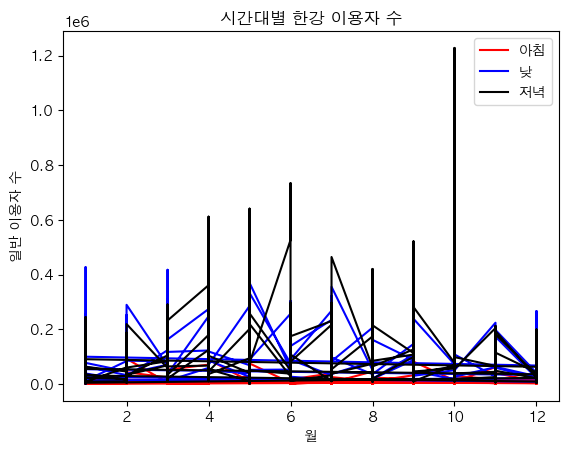

In [26]:
import matplotlib.pyplot as plt

# 아침, 낮, 저녁 컬럼을 사용하여 그래프 그리기
plt.plot(filtered_df.loc[:,['월']], filtered_df['일반이용자(아침)'], label='아침', color = 'red')
plt.plot(filtered_df.loc[:,['월']], filtered_df['일반이용자(낮)'], label='낮', color = 'blue')
plt.plot(filtered_df.loc[:,['월']], filtered_df['일반이용자(저녁)'], label='저녁', color = 'black')

# 레이블과 제목 추가
plt.xlabel('월')
plt.ylabel('일반 이용자 수')
plt.title('시간대별 한강 이용자 수')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

> 그래프에서 한강 이용자 수는 아침이 제일 낮은 비율을 보이는 것을 알 수 있다.       
전반적으로 저녁 > 낮 > 아침 순으로 보인다.

In [27]:
# 일별 데이터와 merge
df = pd.merge(df_merged, filtered_df, how='left', left_on=['지구별','연도','월'], right_on=['지구별','연도','월'])

In [28]:
# 데이터 확인
df

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,주차장 이용 시간(H),평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도(%),일반이용자(아침),일반이용자(낮),일반이용자(저녁)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,381.516667,14.4,10.3,21.0,64.0,NaN,NaN,NaN
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,1106.016667,14.4,10.3,21.0,64.0,NaN,NaN,NaN
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,447.916667,14.4,10.3,21.0,64.0,NaN,NaN,NaN
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,375.150000,14.4,10.3,21.0,64.0,NaN,NaN,NaN
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,2502.250000,14.4,10.3,21.0,64.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,3691.400000,-1.7,-5.5,3.2,43.0,7145.0,37903.0,31569.0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,5.783333,-1.7,-5.5,3.2,43.0,4515.0,42401.0,36832.0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,101.216667,-2.7,-6.4,2.2,44.8,7145.0,37903.0,31569.0
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,1.133333,-2.7,-6.4,2.2,44.8,4515.0,42401.0,36832.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   지구별           45277 non-null  object        
 1   주차장명          45277 non-null  object        
 2   주차대수          45277 non-null  int64         
 3   이용시간          45277 non-null  int64         
 4   날짜            45277 non-null  datetime64[ns]
 5   연도            45277 non-null  int32         
 6   월             45277 non-null  int32         
 7   일             45277 non-null  int32         
 8   요일            45277 non-null  int64         
 9   휴일여부          45277 non-null  int64         
 10  주차장 이용 시간(H)  45277 non-null  float64       
 11  평균기온(°C)      45277 non-null  float64       
 12  최저기온(°C)      45251 non-null  float64       
 13  최고기온(°C)      45277 non-null  float64       
 14  평균 상대습도(%)    45277 non-null  float64       
 15  일반이용자(아침)     34132 non-null  float6

> 월별 데이터인 일반 이용자가 

### 한강 일평균 2024 03월 ~ 09월 데이터 불러오기

In [30]:
df_2024 = pd.read_csv("../Data/한강2403-2409.csv")
df_2024

,전체 이용객,일평균 이용객,현지인 이용객,외지인 이용객,외국인 이용객,자전거 이용객,선호 연령대,선호 시간대,지점
0,"542,887","17,512","290,731","207,393",613,"44,150",50대,14시,광나루
1,"745,458","24,047","342,219","197,152",707,"205,380",0대,0시,잠실
2,"1,078,175","34,780","520,972","491,890","2,056","63,257",20대,16시,뚝섬
3,"511,550","16,502","176,502","262,437","1,821","70,790",40대,16시,잠원
4,"864,064","27,873","275,401","356,962","3,514","228,187",30대,17시,반포
...,...,...,...,...,...,...,...,...,...
72,"1,417,105","47,237","409,861","830,897","12,298","164,049",30대,12시,여의도
73,"727,580","24,253","167,580","310,342","1,432","248,226",30대,18시,양화
74,"584,387","19,480","92,221","387,289","1,753","103,124",30대,16시,난지
75,"613,938","20,465","238,024","311,864","2,433","61,617",20대,19시,망원


---
# Train, Test 데이터 분리

In [31]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor

# # 데이터 프레임 생성

# df = pd.DataFrame({
#     '주차장명' : df_day['주차장명'],
#     '주차대수' : df_day['주차대수'],
#     '주차장 이용시간' : df_day['주차장 이용 시간'],
#     '날짜' : df_day['날짜'],
#     '연도' : df_day['연도'],
#     '월' : df_day['월'],
#     '일' : df_day['일'],
#     '요일' : df_day['요일'],
#     '휴일여부' : df_day['휴일여부']
# })

# # 주차 공간 비율 계산
# df['주차공간비율'] = df['주차장 이용시간'] / df['주차대수']

# features = ['주차대수', '요일', '휴일여부']
# target = '주차공간비율'

# # 데이터 준비
# x = df[features]
# y = df[target]

# X_train, X_test, y_train, y_test = train_test_split(
#                                         x,
#                                         y,
#                                         test_size=0.2,
#                                         random_state=42
# )

# # 모델 학습
# rf = RandomForestRegressor()
# rf.fit(X_train, y_train)

# # 예측
# y_pred = rf.predict(X_test)

# # 예측 결과 확인
# print(f"실제값: {y_test.values}")
# print(f"예측값: {y_pred}")

# # # Data Scaler instance 생성
# # scaler = StandardScaler()
# # # 데이터 스케일링
# # df_scaled = scaler.fit_transform(df[features])

# # # KMeans instance 생성
# # km = KMeans()
# # # K-means 군집화
# # km = KMeans(n_clusters=3, random_state=42)
# # df['K'] = km.fit_predict(df_scaled)

# # 데이터 확인
# df

In [32]:
# # KMeans 군집화 - 사용하고 싶다면 주차 이용률 군집화 가능
# from sklearn.cluster import KMeans
# km = KMeans(n_clusters=4, random_state=42)
# df['K'] = km.fit_predict(X_scaled)  # 군집 결과 추가

# import matplotlib.pyplot as plt

# # Elbow method 
# sse = []
# k_range = range(1, 11)
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_scaled)
#     sse.append(kmeans.inertia_)

# # 엘보우 그래프
# plt.plot(k_range, sse, marker='o')
# plt.title('Elbow Method For Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('SSE')
# plt.show()

---